In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import low_rank_models as lrm

In [2]:
df = pd.read_csv('error_matrix_small.csv', index_col=0)
models = np.array(list(df))             # array of all base models
dataset_IDs = df.index.values           # array of openML dataset IDs used
errorMtx = df.values                
n_datasets, n_models = errorMtx.shape

In [3]:
RANK = 9
X,Y,Vt = lrm.pca(errorMtx, RANK)
lrm.pivoted_qr(Vt)

array([12, 33, 34, 30, 29,  0, 18, 38, 13,  9, 10, 11,  5,  8, 14, 15, 16,
       17,  6, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  4,  3, 31, 32,  1,
        2, 35, 36, 37,  7], dtype=int32)

In [4]:
compute_idx = ()

for dataset in range(n_datasets):
    a = errorMtx[dataset].reshape(1,-1)
    A = np.delete(errorMtx, dataset, axis=0)

    known = []

    for i in range(RANK):
        if i == 0:
            known.append(12)
        else:
            tmp_best = (-1, np.infty)
            for j in range(n_models):
                if j not in known:
                    sampled_cols = np.array(known + [j])
                    a_hat = np.zeros((1, n_models))
                    a_hat[:,sampled_cols] = a[:,sampled_cols]
                    a_hat = lrm.low_rank_approximation(A, a_hat, sampled_cols) 
                    l2_loss = np.linalg.norm(a - a_hat) 
                    if l2_loss < tmp_best[1]:
                        tmp_best = (j, l2_loss)
            known.append(tmp_best[0])
    compute_idx += (np.array(known),)

compute_idx = np.vstack(compute_idx).astype(int)

In [5]:
def sameAlg(testBestCol):
    testBestAlgType = []
    for i in range(len(testBestCol)):
        # testBestAlgType.append(eval(models[testBestCol[i]])['algorithm'])
        testBestAlgType.append(models[testBestCol[i]].split('.')[0])
    return np.array(testBestAlgType)

In [6]:
bestModel = np.argmin(errorMtx, axis=1)
bestAlg = sameAlg(bestModel)
bestError = np.min(errorMtx, axis=1)

methods = ['QR(Vt)', 'Empirical Best']

In [7]:
predictions = {}
for m in methods:    
    predicted = ()
    for i in range(n_datasets):
        a = errorMtx[i].reshape(1,-1)
        A = np.delete(errorMtx, i, axis=0)
        a_hat = np.zeros((1, n_models))
        X,Y,Vt = lrm.pca(A, rank=RANK)
        if m == 'QR(Vt)':
            sampled_cols = lrm.pivoted_qr(Vt)[:RANK]
        elif m == 'Empirical Best':
            sampled_cols = compute_idx[i]
        a_hat[:,sampled_cols] = a[:,sampled_cols]
        a_hat = lrm.low_rank_approximation(A, a_hat, sampled_cols)
        predicted += (np.argsort(a_hat),)
    predictions[m] = np.vstack(predicted)

In [8]:
correct_model = []
correct_alg = []
error_diff = []

for m in methods:
    prediction = predictions[m]
    
    cm = np.zeros(n_models)
    ca = np.zeros((n_datasets, n_models)).astype(int)
    ed = np.zeros((n_datasets, n_models))
    
    for i in range(n_models):
        cm[i] = (prediction[:,i] == bestModel).sum()
        for j in range(n_datasets):
            ed[j,i] = errorMtx[j, prediction[j,i]] - bestError[j]
        if i==0:
            ca[:,i] = sameAlg(prediction[:,i]) == bestAlg
        else:
            ca[:,i] = np.logical_or(ca[:,i-1], sameAlg(prediction[:,i]) == bestAlg)
    for j in range(n_datasets):
        ed[j] = np.minimum.accumulate(ed[j])
            
    correct_model.append(np.cumsum(cm))
    correct_alg.append(np.sum(ca, axis=0))
    error_diff.append(np.mean(ed, axis=0))   

In [9]:
max_entries = 20
fontsize = 11

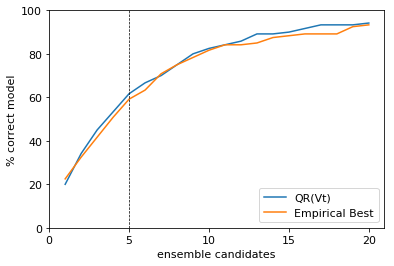

In [10]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
for m in range(len(methods)):
    plt.plot(x, correct_model[m][0:max_entries]*100/n_datasets, label=methods[m])
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks([0,20,40,60,80,100], fontsize=fontsize)
plt.ylabel('% correct model', fontsize=fontsize)
plt.show()

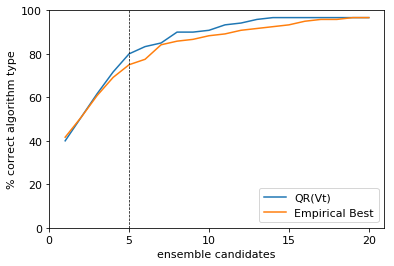

In [11]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
for m in range(len(methods)):
    plt.plot(x, correct_alg[m][0:max_entries]*100/n_datasets, label=methods[m])
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='lower right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks([0,20,40,60,80,100], fontsize=fontsize)
plt.ylabel('% correct algorithm type', fontsize=fontsize)
plt.show()

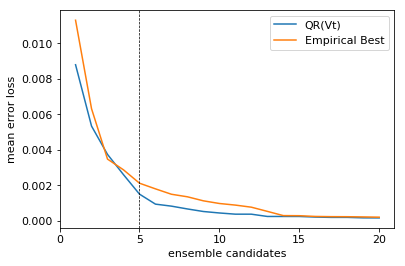

In [12]:
x = np.arange(1, n_models+1, 1)[0:max_entries]
for m in range(len(methods)):
    plt.plot(x, error_diff[m][0:max_entries]*100/n_datasets, label=methods[m])
plt.axvline(x=5, linestyle='dashed', linewidth=0.7, color='black')
plt.legend(loc='upper right', fontsize=fontsize)
plt.xlabel('ensemble candidates', fontsize=fontsize)
plt.xticks(np.arange(0, max_entries + 5, 5), fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel('mean error loss', fontsize=fontsize)
plt.show()